# External objective function evaluation in Bayesian optimization with Emukit

## Overview

The Bayesian optimization component of Emukit allows for objective functions to be evaluated externally. If users opt for this approach, they can use Emukit to suggest the next point for evaluation, and then evaluate the objective function themselves as well as decide on the stopping criteria of the evaluation loop. This notebook shall demonstrate how to carry out this procedure. The main benefit of using Emukit in this manner is that you can externally manage issues such as parallelizing the computation of the objective function, which is convenient in many scenarios.

In [1]:
### General imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
%pylab inline

### --- Figure config
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
LEGEND_SIZE = 15
TITLE_SIZE = 25
AXIS_SIZE = 15

Populating the interactive namespace from numpy and matplotlib


### Navigation

1. [Handling the loop yourself](#1.-Handling-the-loop-yourself)

2. [Comparing with the high level API](#2.-Comparing-with-the-high-level-API)

## 1. Handling the loop yourself

For the purposes of this notebook we are going to use one of the predefined objective functions that come with GPyOpt. However, the key thing to realize is that the function could be anything (e.g., the results of a physical experiment). As long as users are able to externally evaluate the suggested points and provide GPyOpt with the results, the library has options for setting the objective function's origin.

In [2]:
from emukit.test_functions import forrester_function
from emukit.core.loop import UserFunctionWrapper

target_function, space = forrester_function()

First we are going to run the optimization loop outside of Emukit, and only use the library to get the next point at which to evaluate our function.

There are two things to pay attention to when creating the main optimization object:

* Since we recreate the object anew for each iteration, we need to pass data about all previous iterations to it.

* The model gets optimized from the scratch in every iteration but the parameters of the model could be saved and used to update the state (TODO).

We start with three initial points at which we evaluate the objective function.

In [3]:
X = np.array([[0.1],[0.6],[0.9]])
Y = target_function(X)

And we run the loop externally.

In [4]:
from emukit.examples.gp_bayesian_optimization.single_objective_bayesian_optimization import GPBayesianOptimization
from emukit.core.loop import UserFunctionResult

num_iterations = 10

bo = GPBayesianOptimization(variables_list=space.parameters, X=X, Y=Y)
results = None

for _ in range(num_iterations):
    X_new = bo.get_next_points(results)
    Y_new = target_function(X_new)
    results = [UserFunctionResult(X_new[0], Y_new[0])]

X = bo.loop_state.X
Y = bo.loop_state.Y

Let's visualize the results. The size of the marker denotes the order in which the point was evaluated - the bigger the marker the later was the evaluation.

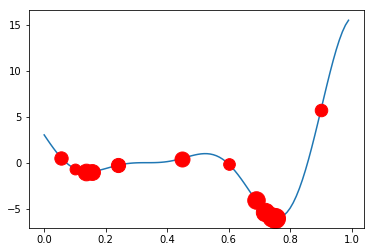

In [5]:
x = np.arange(0.0, 1.0, 0.01)
y = target_function(x)

plt.figure()
plt.plot(x, y)
for i, (xs, ys) in enumerate(zip(X, Y)):
    plt.plot(xs, ys, 'ro', markersize=10 + 10 * (i+1)/len(X))

In [6]:
X

array([[0.1       ],
       [0.6       ],
       [0.9       ],
       [0.0549192 ],
       [0.24163332],
       [0.44706868],
       [0.15537258],
       [0.13687813],
       [0.6888019 ],
       [0.71922108],
       [0.73967583],
       [0.75168362]])

## 2. Comparing with the high level API

To compare the results, let's now execute the whole loop with Emukit.

In [7]:
X = np.array([[0.1],[0.6],[0.9]])
Y = target_function(X)

bo_loop = GPBayesianOptimization(variables_list=space.parameters, X=X, Y=Y)
bo_loop.run_optimization(target_function, num_iterations)

Now let's print the results of this optimization and compare it to the previous external evaluation run. As before, the size of the marker corresponds to its evaluation order.

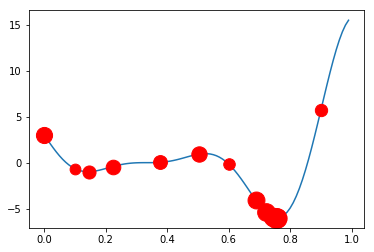

In [8]:
x = np.arange(0.0, 1.0, 0.01)
y = target_function(x)

plt.figure()
plt.plot(x, y)
for i, (xs, ys) in enumerate(zip(bo_loop.model.model.X, bo_loop.model.model.Y)):
    plt.plot(xs, ys, 'ro', markersize=10 + 10 * (i+1)/len(bo_loop.model.model.X))

It can be observed that we obtain the same result as before but now the objective function is handled internally.